In [336]:
import pandas as pd
pd.options.display.max_seq_items = 2000

# Random Forest Modelling

### Data Preparation

In [337]:
journey_train = pd.read_csv('../data/processed/journey_data_2018_01.csv', parse_dates=['end_date', 'start_date'], index_col=0)
journey_test = pd.read_csv('../data/processed/journey_data_2019_01.csv', parse_dates=['end_date', 'start_date'], index_col=0)

In [338]:
journey_train.head()

,rental_id,end_date,end_station_name,start_date,start_station_name,day_of_week,hour,is_weekend,part_of_day,month,...,election_seats_percentage_lab,election_seats_percentage_ld,election_seats_percentage_gre,election_seats_percentage_ind,occupation_high_level_ratio_ratio,occupation_small_intermediate_ratio_ratio,occupation_lower_level_ratio_ratio,occupation_unemployed_ratio_ratio,occupation_student_ratio_ratio,earnings_workplace
0,72337672.0,2018-01-01 00:07:00,"Millbank Tower, Pimlico",2018-01-01 00:00:00,"Grosvenor Road, Pimlico",0,0,0.0,5,1.0,...,0.320000,0.000000,0.000000,0.000000,0.443089,0.161098,0.148262,0.118178,0.129374,60046.0
1,72337673.0,2018-01-01 01:16:00,"South Parade, Chelsea",2018-01-01 00:02:00,"South Parade, Chelsea",0,0,0.0,5,1.0,...,0.260000,0.020000,0.000000,0.000000,0.460353,0.177567,0.144639,0.104780,0.112661,41723.0
2,72337675.0,2018-01-01 00:58:00,"Portman Square, Marylebone",2018-01-01 00:02:00,"Portman Square, Marylebone",0,0,0.0,5,1.0,...,0.320000,0.000000,0.000000,0.000000,0.443089,0.161098,0.148262,0.118178,0.129374,60046.0
3,72337676.0,2018-01-01 00:59:00,"Portman Square, Marylebone",2018-01-01 00:02:00,"Portman Square, Marylebone",0,0,0.0,5,1.0,...,0.320000,0.000000,0.000000,0.000000,0.443089,0.161098,0.148262,0.118178,0.129374,60046.0
4,72337679.0,2018-01-01 14:11:00,"Stockwell Roundabout, Stockwell",2018-01-01 00:02:00,"New Fetter Lane, Holborn",0,0,0.0,5,1.0,...,0.733636,0.027273,0.010909,0.003636,0.635932,0.125062,0.084708,0.054598,0.099700,88145.0


In [339]:
# aggregate demand for each borough by summing
journey_train['demand'] = 1
journey_test['demand'] = 1

# caet a list of all column names except 'demand' and 'start_date'
column_names = [col for col in journey_train.columns]

# create a dictionary with all features, first -> always keep values of first element
aggregate_functions = {col: 'first' for col in column_names}

# add an entry for the 'demand' column with 'sum' as the aggregate function
aggregate_functions['demand'] = 'sum'

# round down the datetime to the nearest hour
journey_train['start_date_hour'] = journey_train['start_date'].dt.floor('H')
journey_test['start_date_hour'] = journey_test['start_date'].dt.floor('H')

# perform the groupby operation
journey_train_hourly = journey_train.groupby(['start_date_hour', 'start_borough']).agg(aggregate_functions)
journey_test_hourly = journey_test.groupby(['start_date_hour', 'start_borough']).agg(aggregate_functions)

# one hot encoding start_borough
journey_train_hourly = pd.get_dummies(journey_train_hourly, columns=['start_borough'])
journey_test_hourly = pd.get_dummies(journey_test_hourly, columns=['start_borough'])

journey_train_hourly = journey_train_hourly.reset_index()
journey_test_hourly = journey_test_hourly.reset_index()


# create the target variables
y_train = journey_train_hourly['demand']
y_test = journey_test_hourly['demand']

# create the predictor variables
cols_to_remove = ['rental_id', 'end_date', 'end_borough', 'start_date', 'end_station_name', 'start_station_name', 'demand', 'borough', 'borough_code', 'year', 'start_borough', 'start_date_hour']
x_train = journey_train_hourly.drop(columns=cols_to_remove)
x_test = journey_test_hourly.drop(columns=cols_to_remove)


In [340]:
y_train.shape

(8152,)

In [341]:
x_train.shape

(8152, 106)

In [342]:
x_train.head(20)

,day_of_week,hour,is_weekend,part_of_day,month,season,bank_holiday,tempmax,tempmin,temp,...,start_borough_Hackney,start_borough_Hammersmith and Fulham,start_borough_Islington,start_borough_Kensington and Chelsea,start_borough_Lambeth,start_borough_Newham,start_borough_Southwark,start_borough_Tower Hamlets,start_borough_Wandsworth,start_borough_Westminster
0,0,0,0.0,5,1.0,4,1.0,8.1,6.1,7.1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0.0,5,1.0,4,1.0,8.1,6.1,7.1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0.0,5,1.0,4,1.0,8.1,6.1,7.1,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0.0,5,1.0,4,1.0,8.1,6.1,7.1,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0.0,5,1.0,4,1.0,8.1,6.1,7.1,...,0,0,1,0,0,0,0,0,0,0
5,0,0,0.0,5,1.0,4,1.0,8.1,6.1,7.1,...,0,0,0,1,0,0,0,0,0,0
6,0,0,0.0,5,1.0,4,1.0,8.1,6.1,7.1,...,0,0,0,0,1,0,0,0,0,0
7,0,0,0.0,5,1.0,4,1.0,8.1,6.1,7.1,...,0,0,0,0,0,0,1,0,0,0
8,0,0,0.0,5,1.0,4,1.0,8.1,6.1,7.1,...,0,0,0,0,0,0,0,1,0,0
9,0,0,0.0,5,1.0,4,1.0,8.1,6.1,7.1,...,0,0,0,0,0,0,0,0,1,0


### Model: Random Forest

In [356]:
from sklearn.ensemble import RandomForestRegressor

# Initialize a Random Forest Regressor
rf = RandomForestRegressor(n_estimators=300, random_state=42)

# Fit the model on the train data
rf.fit(x_train, y_train)

# Predict on the test set
y_pred = rf.predict(x_test)

In [357]:
# Get feature importances
importances = rf.feature_importances_

# Create a DataFrame to display the feature importances
feature_importances = pd.DataFrame({'Feature': x_train.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values('Importance', ascending=False)

# Display the feature importances
print(feature_importances)

                                       Feature  Importance
1                                         hour    0.305499
3                                  part_of_day    0.152966
15                                  cloudcover    0.062900
33              ethnic_african_caribbean_ratio    0.035843
0                                  day_of_week    0.034683
12                                      precip    0.023967
76               residence_lengh_uk_born_ratio    0.021904
21                         bike_station_counts    0.021581
22                           bike_docks_counts    0.020431
20                                 day_of_year    0.019862
36                     ethnic_arab_other_ratio    0.018893
58                         crime_offences_rate    0.018416
105                  start_borough_Westminster    0.018228
16                                  visibility    0.018163
50                              health_1_ratio    0.018138
9                                         temp    0.0174

RMSE: 63.64318391306609
MAE: 30.215517879762253
R2 Score: 0.729397860220171
Explained Variance Score: 0.7412481508515865


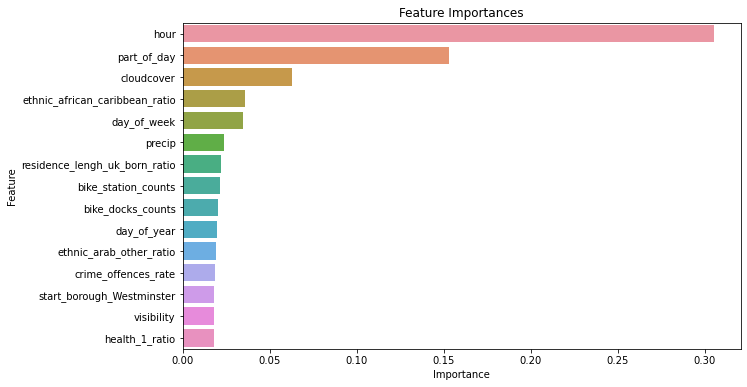

In [358]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, explained_variance_score

# Calculate updated evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)

print('RMSE:', rmse)
print('MAE:', mae)
print('R2 Score:', r2)
print('Explained Variance Score:', evs)

# Visualize Feature Importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances[:15])
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


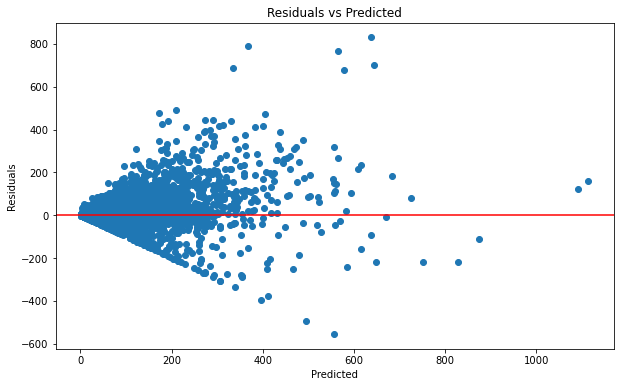

In [359]:
import matplotlib.pyplot as plt

# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(10,6))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.show()


Heteroscedasticity: the variance of the residuals increases as the predicted values increase

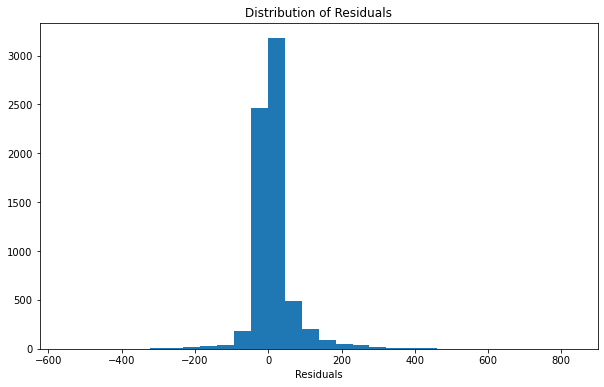

In [360]:
plt.figure(figsize=(10,6))
plt.hist(residuals, bins=30)
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')
plt.show()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define the hyperparameter grid
param_grid = {
    'n_estimators': randint(100, 1000),  # Number of trees in the random forest
    'max_features': ['auto', 'sqrt'],  # Number of features to consider at each split
    'max_depth': randint(5, 20),  # Maximum depth of the tree
    'min_samples_split': randint(2, 10),  # Minimum number of samples required to split a node
    'min_samples_leaf': randint(1, 10)  # Minimum number of samples required at each leaf node
}

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Perform Randomized Search with 10 iterations
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=10, cv=5, random_state=42)

# Fit the random search on the train data
random_search.fit(x_train, y_train)

# Get the best model and its hyperparameters
best_rf = random_search.best_estimator_
best_params = random_search.best_params_

print("Best Hyperparameters:", best_params)

# Predict on the test set using the best model
y_pred_best = best_rf.predict(x_test)

# Calculate updated evaluation metrics
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
mae_best = mean_absolute_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)
evs_best = explained_variance_score(y_test, y_pred_best)

print('Best Model RMSE:', rmse_best)
print('Best Model MAE:', mae_best)
print('Best Model R2 Score:', r2_best)
print('Best Model Explained Variance Score:', evs_best)


### Model: Gradient Boosting

In [346]:
from sklearn.ensemble import GradientBoostingRegressor

# Initialize a Gradient Boosting Regressor
gb = GradientBoostingRegressor(n_estimators=400, learning_rate=0.1, random_state=42)

# Fit the model on the train data
gb.fit(x_train, y_train)

# Predict on the test set
y_pred_gb = gb.predict(x_test)


In [351]:
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, explained_variance_score

# Calculate updated evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred_gb))
mae = mean_absolute_error(y_test, y_pred_gb)
r2 = r2_score(y_test, y_pred_gb)
evs = explained_variance_score(y_test, y_pred_gb)

print('RMSE:', rmse)
print('MAE:', mae)
print('R2 Score:', r2)
print('Explained Variance Score:', evs)


Tuned RMSE: 68.25785782683776
Tuned MAE: 38.353955525305864
Tuned R2 Score: 0.6887332444104759
Tuned Explained Variance Score: 0.7200027096601362
